In [2]:
# %%
import os
import sys

from matplotlib import animation
sys.path.append("/home/wladekpal/crl_subgoal/src")
# %%
import functools
import os
import distrax


import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
from envs import block_moving
import matplotlib.pyplot as plt
from impls.utils.networks import GCDiscreteActor
from envs.block_moving_env import *
import copy
import numpy as np




In [3]:
# %%
RANGE_GENERALIZATION = [1,2,3,4,5,6,7,9,11]
EPISODE_LENGTH = 100
NUM_ENVS = 50
CHECKPOINT = 50
RUN_NAME = f"DQN{CHECKPOINT}_investigation"
MODEL_PATH = "/home/wladekpal/crl_subgoal/runs/rendering_td_gcdqn_small_4_boxes_6_grid"
EPOCHS = 51
EVAL_EVERY = 10
FIGURES_PATH = f"/figures/{RUN_NAME}"
GIF_PATH = f"{FIGURES_PATH}/gifs"

# os.makedirs(GIF_PATH, exist_ok=True)


In [4]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test", num_envs=NUM_ENVS),
    env=BoxPushingConfig(
        level_generator='variable',
        grid_size=6,
        generator_special=False,
        number_of_boxes_min=4,
        number_of_boxes_max=4,
        number_of_moving_boxes_max=4
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [5]:


example_batch = {
    "observations": dummy_timestep.grid.reshape(1, -1),  # Add batch dimension
    "next_observations": dummy_timestep.grid.reshape(1, -1),
    "actions": jnp.ones((1,), dtype=jnp.int8)
    * (env._env.action_space - 1),  # it should be the maximal value of action space
    "rewards": jnp.ones((1,), dtype=jnp.int8),
    "masks": jnp.ones((1,), dtype=jnp.int8),
    "value_goals": dummy_timestep.grid.reshape(1, -1),
    "actor_goals": dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)


# %%
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)


Restored from /home/wladekpal/crl_subgoal/runs/rendering_td_gcdqn_small_4_boxes_6_grid/params_50.pkl


In [6]:

def make_batch(buffer_state, key):
    key, sampling_key, batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, next_state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, next_state, future_state, goal_index = get_single_pair_from_every_env(
        state,
        next_state,
        future_state,
        goal_index,
        sampling_key,
    )
    if not config.exp.use_targets:
        state = state.replace(grid=remove_targets(state.grid))
        next_state = next_state.replace(grid=remove_targets(next_state.grid))
        future_state = future_state.replace(grid=remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        "observations": state.grid.reshape(state.grid.shape[0], -1),
        "next_observations": next_state.grid.reshape(next_state.grid.shape[0], -1),
        "actions": actions.squeeze(),
        "rewards": state.reward.reshape(state.reward.shape[0], -1).squeeze(),
        "masks": 1.0 - state.done.reshape(state.done.shape[0], -1).squeeze(),
        "value_goals": future_state.grid.reshape(future_state.grid.shape[0], -1),
        "actor_goals": future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch

In [7]:
data_key = random.PRNGKey(3)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)

print(timesteps.grid.shape)

(100, 1024, 6, 6)


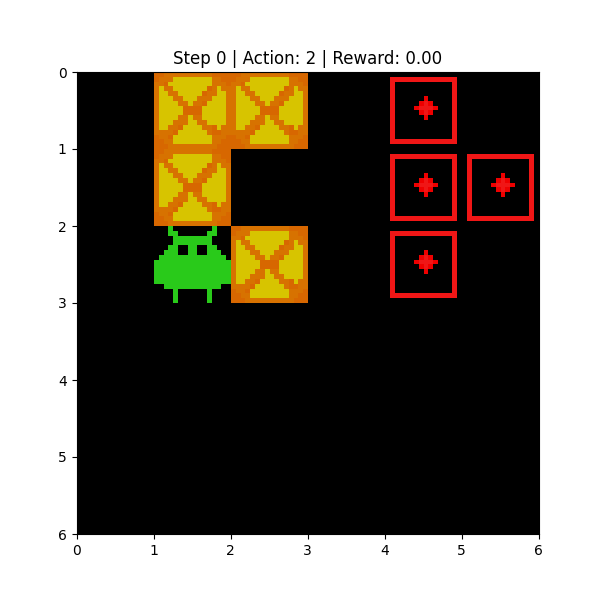

In [8]:
import IPython.display as display

grid_size = state.grid.shape[-2:]
fig, ax = plt.subplots(figsize=grid_size)


animate = functools.partial(env.animate, ax, jax.tree_util.tree_map(lambda x: x.swapaxes(1, 0), timesteps), img_prefix=os.path.join(ROOT_DIR, 'assets'))

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)

# Save as GIF
gif_path = f"block_moving_epoch.gif"
anim.save(gif_path, writer='pillow')
plt.close()


# Visualize the GIF in the notebook
display.display(display.Image(filename=gif_path))

In [9]:
jnp.save("trajectory_4_train.npy", timesteps.grid)